# Part 1 - Crawler 
Get the historical and current stock price of the specified stock  

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import datetime as dt
import json
import sys
import talib
import operator
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter,FixedFormatter
from pymongo import MongoClient
from datetime import datetime
# Print the result immediately
sys.stdout.flush()

In [3]:
# Read from yahoo finance
def crawl_db(symbol, start, end, db):    
    df = web.DataReader(symbol, 'yahoo', start, end)
    df['Date'] = df.index
    # Save
    db.stock.insert_one({
        "symbol": symbol,
        "data": df.to_dict("records")
    })

client = MongoClient('localhost', 27017)
db = client.istock
start = dt.datetime(2005, 1, 1)
end   = dt.datetime(2015, 12, 31)
symbols = [line.strip() for line in open("sp500.txt","r")]
for symbol in symbols:
    # If the symbol haven't been crawled
    if db.stock.find({"symbol": symbol}).count() == 0:
        try:
            print(symbol)
            crawl_db(symbol, start, end, db)
        except:
            print("Unexpected error:", sys.exc_info()[0])

FTV
Unexpected error: <class 'pandas_datareader._utils.RemoteDataError'>
NEE
Unexpected error: <class 'pandas_datareader._utils.RemoteDataError'>
WLTW
Unexpected error: <class 'pandas_datareader._utils.RemoteDataError'>


## 1-1.Preprocessing
### Feature Engineering

In [11]:
def build_feature(doc):
    df = pd.DataFrame.from_dict(doc['data'])
    # Set Date as Index
    df = df.set_index('Date')

    close = np.array(df['Adj Close'])
    op = np.array(df['Open'])
    high = np.array(df['High'])
    low = np.array(df['Low'])
    close = np.array(df['Adj Close'])
    volume = np.array(df['Volume'], dtype='float')

    # (Deprecated) Hand-made features, replaced by talib
    # df['sma5'] = np.round(pd.rolling_mean(df['Adj Close'], window=5),2)
    # df['sma10'] = np.round(pd.rolling_mean(df['Adj Close'], window=10),2)
    # df['sma20'] = np.round(pd.rolling_mean(df['Adj Close'], window=20),2)
    # df['willr'] = (df['High']-df['Adj Close']) / (df['High']-df['Low'])
    # Log_Ret = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    # df['volatility'] = pd.rolling_std(Log_Ret, window=252) * np.sqrt(252) 
    
    # Today's price higher than yesturday by 0.5% --> Good!
    # Today's price lower than yesturday by 0.5% --> Bad!
    # Other --> Nothing happen
    df['trend'] = 0
    df.loc[df['Adj Close'] > df['Adj Close'].shift(1)*1.005, 'trend'] = 1
    df.loc[df['Adj Close'] < df['Adj Close'].shift(1)*0.995, 'trend'] = -1
    
    # Datetime
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day

    # Techinical analysis indicators 
    # Calculated by ta-lib (https://github.com/mrjbq7/ta-lib)
    # Overlap Studies
    upperband, middleband, lowerband = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['bband_width'] = ( (upperband-lowerband)/middleband).tolist()
    df['bband_upper_signal'] = (close > upperband)*1
    df['bband_lower_signal'] = (close < lowerband)*1

    df['dema'] = talib.DEMA(close, timeperiod=30).tolist()
    df['ema'] = talib.EMA(close, timeperiod=30).tolist()
    df['ht_trendline'] = talib.HT_TRENDLINE(close).tolist()
    df['kmam'] = talib.KAMA(close, timeperiod=30).tolist()
    df['midpoint'] = talib.MIDPOINT(close, timeperiod=14).tolist()
    df['midprice'] = talib.MIDPRICE(high, low, timeperiod=14).tolist()
    df['sar'] = talib.SAR(high, low, acceleration=0, maximum=0).tolist()
    df['sarext'] = talib.SAREXT(high, low, startvalue=0, offsetonreverse=0, accelerationinitlong=0,
                                accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, 
                                accelerationshort=0, accelerationmaxshort=0).tolist()
    df['sma3'] = talib.SMA(close, timeperiod=3).tolist()
    df['sma5'] = talib.SMA(close, timeperiod=5).tolist()
    df['sma10'] = talib.SMA(close, timeperiod=10).tolist()
    df['sma20'] = talib.SMA(close, timeperiod=20).tolist()

    df['t3'] = talib.T3(close, timeperiod=5, vfactor=0).tolist()
    df['tema'] = talib.TEMA(close, timeperiod=30).tolist()
    df['trima'] = talib.TRIMA(close, timeperiod=30).tolist()
    df['wma'] = talib.WMA(close, timeperiod=30).tolist()

    # Momentum Indicators
    df['adx14'] = talib.ADX(high, low, close, timeperiod=14).tolist()
    df['adx20'] = talib.ADX(high, low, close, timeperiod=20).tolist()
    df['adxr'] = talib.ADXR(high, low, close, timeperiod=14).tolist()
    df['apo'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0).tolist()
    df['aroonosc'] = talib.AROONOSC(high, low, timeperiod=14).tolist()
    df['bop'] = talib.BOP(op, high, low, close).tolist()
    df['cci3'] = talib.CCI(high, low, close, timeperiod=3).tolist()
    df['cci5'] = talib.CCI(high, low, close, timeperiod=5).tolist()
    df['cci10'] = talib.CCI(high, low, close, timeperiod=10).tolist()
    df['cci14'] = talib.CCI(high, low, close, timeperiod=14).tolist()
    df['cmo'] = talib.CMO(close, timeperiod=14).tolist()
    df['dx'] = talib.DX(high, low, close, timeperiod=14).tolist()
    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df['macd'] = macd.tolist()
    df['macdsignal'] = macdsignal.tolist()
    df['macdhist'] = macdhist.tolist()

    df['mfi'] = talib.MFI(high, low, close, volume, timeperiod=14).tolist()
    df['minus_di'] = talib.MINUS_DI(high, low, close, timeperiod=14).tolist()
    df['minus_dm'] = talib.MINUS_DM(high, low, timeperiod=14).tolist()
    df['mom1'] = talib.MOM(close, timeperiod=1).tolist()
    df['mom3'] = talib.MOM(close, timeperiod=3).tolist()
    df['mom5'] = talib.MOM(close, timeperiod=5).tolist()
    df['mom10'] = talib.MOM(close, timeperiod=10).tolist()
    df['plus_di'] = talib.PLUS_DI(high, low, close, timeperiod=14).tolist()
    df['plus_dm'] = talib.PLUS_DM(high, low, timeperiod=14).tolist()
    df['ppo'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0).tolist()
    df['roc'] = talib.ROC(close, timeperiod=10).tolist()
    df['rocp'] = talib.ROCP(close, timeperiod=10).tolist()
    df['rocr'] = talib.ROCR(close, timeperiod=10).tolist()
    df['rocr100'] = talib.ROCR100(close, timeperiod=10).tolist()
    df['rsi5'] = talib.RSI(close, timeperiod=5).tolist()    
    df['rsi10'] = talib.RSI(close, timeperiod=10).tolist()    
    df['rsi14'] = talib.RSI(close, timeperiod=14).tolist()

    # Famous KD line
    slowk, slowd = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['slowk'] = slowk.tolist()
    df['slowd'] = slowd.tolist()

    fastk, fastd = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['fastk'] = fastk.tolist()
    df['fastd'] = fastd.tolist()
    # fastk, fastd = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)


    df['trix'] = talib.TRIX(close, timeperiod=30).tolist()
    df['ultosc'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28).tolist()
    df['willr'] = talib.WILLR(high, low, close, timeperiod=14).tolist()

    # Volume Indicators
    df['ad'] = talib.AD(high, low, close, volume).tolist()
    df['adosc'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10).tolist()

    # Volatility Indicators
    df['atr'] = talib.ATR(high, low, close, timeperiod=14).tolist()
    df['natr'] = talib.NATR(high, low, close, timeperiod=14).tolist()
    df['trange'] = talib.TRANGE(high, low, close).tolist()

    # Pattern Recognition
    df['cdl2crows'] = talib.CDL2CROWS(op, high, low, close).tolist()
    df['cdl3blackcrows'] = talib.CDL3BLACKCROWS(op, high, low, close).tolist()
    df['cdl3inside'] = talib.CDL3INSIDE(op, high, low, close).tolist()
    df['cdl3linestrike'] = talib.CDL3LINESTRIKE(op, high, low, close).tolist()
    df['cdl3outside'] = talib.CDL3OUTSIDE(op, high, low, close).tolist()
    df['cdl3starsinsouth'] = talib.CDL3STARSINSOUTH(op, high, low, close).tolist()
    df['cdl3whitesoldiers'] = talib.CDL3WHITESOLDIERS(op, high, low, close).tolist()
    df['cdlabandonedbaby'] = talib.CDLABANDONEDBABY(op, high, low, close, penetration=0).tolist()
    df['cdladvanceblock'] = talib.CDLADVANCEBLOCK(op, high, low, close).tolist()
    df['cdlbelthold'] = talib.CDLBELTHOLD(op, high, low, close).tolist()
    df['cdlbreakaway'] = talib.CDLBREAKAWAY(op, high, low, close).tolist()
    df['cdlclosingmarubozu'] = talib.CDLCLOSINGMARUBOZU(op, high, low, close).tolist()
    df['cdlconcealbabyswall'] = talib.CDLCONCEALBABYSWALL(op, high, low, close).tolist()
    df['cdlcounterattack'] = talib.CDLCOUNTERATTACK(op, high, low, close).tolist()
    df['cdldarkcloudcover'] = talib.CDLDARKCLOUDCOVER(op, high, low, close, penetration=0).tolist()
    df['cdldoji'] = talib.CDLDOJI(op, high, low, close).tolist()
    df['cdldojistar'] = talib.CDLDOJISTAR(op, high, low, close).tolist()
    df['cdldragonflydoji'] = talib.CDLDRAGONFLYDOJI(op, high, low, close).tolist()
    df['cdlengulfing'] = talib.CDLENGULFING(op, high, low, close).tolist()
    df['cdleveningdojistar'] = talib.CDLEVENINGDOJISTAR(op, high, low, close, penetration=0).tolist()
    df['cdleveningstar'] = talib.CDLEVENINGSTAR(op, high, low, close, penetration=0).tolist()
    df['cdlgapsidesidewhite'] = talib.CDLGAPSIDESIDEWHITE(op, high, low, close).tolist()
    df['cdlgravestonedoji'] = talib.CDLGRAVESTONEDOJI(op, high, low, close).tolist()
    df['cdlhammer'] = talib.CDLHAMMER(op, high, low, close).tolist()
    df['cdlhangingman'] = talib.CDLHANGINGMAN(op, high, low, close).tolist()
    df['cdlharami'] = talib.CDLHARAMI(op, high, low, close).tolist()
    df['cdlharamicross'] = talib.CDLHARAMICROSS(op, high, low, close).tolist()
    df['cdlhighwave'] = talib.CDLHIGHWAVE(op, high, low, close).tolist()
    df['cdlhikkake'] = talib.CDLHIKKAKE(op, high, low, close).tolist()
    df['cdlhikkakemod'] = talib.CDLHIKKAKEMOD(op, high, low, close).tolist()
    df['cdlhomingpigeon'] = talib.CDLHOMINGPIGEON(op, high, low, close).tolist()
    df['cdlidentical3crows'] = talib.CDLIDENTICAL3CROWS(op, high, low, close).tolist()
    df['cdlinneck'] = talib.CDLINNECK(op, high, low, close).tolist()
    df['cdlinvertedhammer'] = talib.CDLINVERTEDHAMMER(op, high, low, close).tolist()
    df['cdlkicking'] = talib.CDLKICKING(op, high, low, close).tolist()
    df['cdlkickingbylength'] = talib.CDLKICKINGBYLENGTH(op, high, low, close).tolist()
    df['cdlladderbottom'] = talib.CDLLADDERBOTTOM(op, high, low, close).tolist()
    df['cdllongleggeddoji'] = talib.CDLLONGLEGGEDDOJI(op, high, low, close).tolist()
    df['cdllongline'] = talib.CDLLONGLINE(op, high, low, close).tolist()
    df['cdlmarubozu'] = talib.CDLMARUBOZU(op, high, low, close).tolist()
    df['cdlmatchinglow'] = talib.CDLMATCHINGLOW(op, high, low, close).tolist()
    df['cdlmathold'] = talib.CDLMATHOLD(op, high, low, close, penetration=0).tolist()
    df['cdlmorningdojistar'] = talib.CDLMORNINGDOJISTAR(op, high, low, close, penetration=0).tolist()
    df['cdlmorningstar'] = talib.CDLMORNINGSTAR(op, high, low, close, penetration=0).tolist()
    df['cdlonneck'] = talib.CDLONNECK(op, high, low, close).tolist()
    df['cdlpiercing'] = talib.CDLPIERCING(op, high, low, close).tolist()
    df['cdlrickshawman'] = talib.CDLRICKSHAWMAN(op, high, low, close).tolist()
    df['cdlrisefall3methods'] = talib.CDLRISEFALL3METHODS(op, high, low, close).tolist()
    df['cdlseparatinglines'] = talib.CDLSEPARATINGLINES(op, high, low, close).tolist()
    df['cdlshootingstar'] = talib.CDLSHOOTINGSTAR(op, high, low, close).tolist()
    df['cdlshortline'] = talib.CDLSHORTLINE(op, high, low, close).tolist()
    df['cdlspinningtop'] = talib.CDLSPINNINGTOP(op, high, low, close).tolist()
    df['cdlstalledpattern'] = talib.CDLSTALLEDPATTERN(op, high, low, close).tolist()
    df['cdlsticksandwich'] = talib.CDLSTICKSANDWICH(op, high, low, close).tolist()
    df['cdltakuri'] = talib.CDLTAKURI(op, high, low, close).tolist()
    df['cdltasukigap'] = talib.CDLTASUKIGAP(op, high, low, close).tolist()
    df['cdlthrusting'] = talib.CDLTHRUSTING(op, high, low, close).tolist()
    df['cdltristar'] = talib.CDLTRISTAR(op, high, low, close).tolist()
    df['cdlunique3river'] = talib.CDLUNIQUE3RIVER(op, high, low, close).tolist()
    df['cdlupsidegap2crows'] = talib.CDLUPSIDEGAP2CROWS(op, high, low, close).tolist()
    df['cdlxsidegap3methods'] = talib.CDLXSIDEGAP3METHODS(op, high, low, close).tolist()

    # Cycle Indicators
    df['ht_dcperiod'] = talib.HT_DCPERIOD(close).tolist()
    df['ht_dcphase'] = talib.HT_DCPHASE(close).tolist()
    # df['inphase, quadrature'] = talib.HT_PHASOR(close).tolist()
    # df['sine, leadsine'] = talib.HT_SINE(close).tolist()
    df['ht_trendmode'] = talib.HT_TRENDMODE(close).tolist()
    


    # Check out where are the nans
    # print(df.isnull().values.any())

    # Since we have enough data & most of nan happen during calculating indicators
    # So I chose to drop it directly
    df = df.dropna()
    mongo_update(df, doc)
    return df

In [12]:
def mongo_update(df, doc):
    df['Date'] = df.index
    db.stock.update_one(
        {"symbol": doc['symbol']},
        {"$set": {"data":df.to_dict("records")}}
    )

In [13]:
## from threading import Thread
# Build features for all S&P 500 companys
# cursor = db.stock.find()
# for doc in cursor:
#     print(doc['symbol'])
#     t = Thread(target=build_feature, args=(doc,))
#     t.start()

# Build features for single company
cursor = db.stock.find({'symbol': 'AAPL'})
df_tmp = build_feature(cursor[0])

## Build features for selected companys
# symbols = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
# df_tmp = ""
# for symbol in symbols:
#     cursor = db.stock.find({'symbol': symbol})
#     df_tmp = build_feature(cursor[0])

In [14]:
df_tmp.columns.tolist()

['Adj Close',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'ad',
 'adosc',
 'adx14',
 'adx20',
 'adxr',
 'apo',
 'aroonosc',
 'atr',
 'bband_lower_signal',
 'bband_upper_signal',
 'bband_width',
 'bop',
 'cci10',
 'cci14',
 'cci3',
 'cci5',
 'cdl2crows',
 'cdl3blackcrows',
 'cdl3inside',
 'cdl3linestrike',
 'cdl3outside',
 'cdl3starsinsouth',
 'cdl3whitesoldiers',
 'cdlabandonedbaby',
 'cdladvanceblock',
 'cdlbelthold',
 'cdlbreakaway',
 'cdlclosingmarubozu',
 'cdlconcealbabyswall',
 'cdlcounterattack',
 'cdldarkcloudcover',
 'cdldoji',
 'cdldojistar',
 'cdldragonflydoji',
 'cdlengulfing',
 'cdleveningdojistar',
 'cdleveningstar',
 'cdlgapsidesidewhite',
 'cdlgravestonedoji',
 'cdlhammer',
 'cdlhangingman',
 'cdlharami',
 'cdlharamicross',
 'cdlhighwave',
 'cdlhikkake',
 'cdlhikkakemod',
 'cdlhomingpigeon',
 'cdlidentical3crows',
 'cdlinneck',
 'cdlinvertedhammer',
 'cdlkicking',
 'cdlkickingbylength',
 'cdlladderbottom',
 'cdllongleggeddoji',
 'cdllongline',
 'cdlmarubozu',
 'cdlma

# Part 2 - Data Visualization
Visualize historical stock price of the stock selected

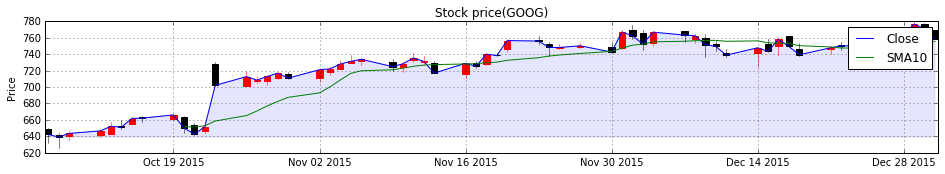

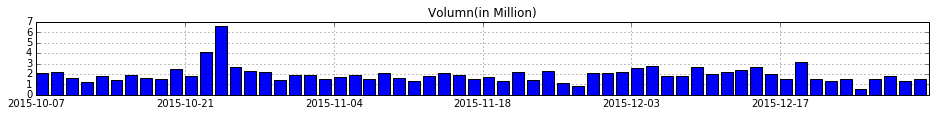

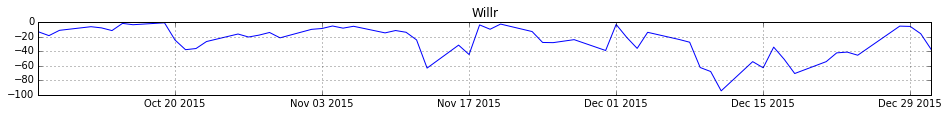

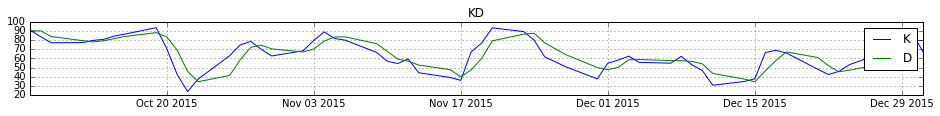

In [15]:
%matplotlib inline
from matplotlib.finance import candlestick_ohlc
from matplotlib.ticker import Formatter
symbol = "GOOG"
cursor = db.stock.find({"symbol": symbol})
df = pd.DataFrame.from_dict(cursor[0]['data'])
df = df.set_index('Date')
df = df.tail(60)

df['SMA10'] = talib.SMA(np.array(df['Close']), timeperiod=10).tolist()

plt.figure(figsize=(16, 12), dpi=300)
plt.subplot(411)
plt.title("Stock price("+symbol+")")
plt.ylabel("Price")
plt.plot(df['Close'], label="Close")
plt.plot(df['SMA10'], label="SMA10")
plt.grid(True)
plt.legend()
plt.fill_between(df.index, df['Close'].min(), df['Close'], facecolor='blue', alpha=0.1)

ax = plt.gca()
fig = plt.gcf()
tmp = df.ix[:,1:6]
tmp['date'] = mpl.dates.date2num(df.index.to_pydatetime())
cols = tmp.columns.tolist()
cols = cols[-1:] + cols[:-1]
quotes = tmp[cols].values.tolist()
fig.subplots_adjust(bottom=0.2)
candlestick_ohlc(ax, quotes, width=0.6)

class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%Y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''

        return self.dates[ind].strftime(self.fmt)

formatter = MyFormatter(df.index)
plt.figure(figsize=(16, 6), dpi=300)
plt.subplot(412)
plt.title("Volumn(in Million)")
plt.bar(np.arange(len(df['Volume'])), df['Volume']/1000000)
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)

plt.figure(figsize=(16, 6), dpi=300)
plt.subplot(413)
plt.title("Willr")
plt.plot(df['willr'])
plt.grid(True)

plt.figure(figsize=(16, 6), dpi=300)
plt.subplot(414)
plt.title("KD")
plt.plot(df['slowk'], label="K")
plt.plot(df['slowd'], label="D")
plt.legend()
plt.grid(True)

# Part 3 - Time series prediction 
## Regression + Feature Importance

training data processed
Train a XGBoost model
[0]	train-rmspe:0.980472	eval-rmspe:0.980192
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmspe:0.933372	eval-rmspe:0.932427
[2]	train-rmspe:0.848788	eval-rmspe:0.848177
[3]	train-rmspe:0.733664	eval-rmspe:0.734933
[4]	train-rmspe:0.604401	eval-rmspe:0.604756
[5]	train-rmspe:0.478396	eval-rmspe:0.479452
[6]	train-rmspe:0.366865	eval-rmspe:0.369336
[7]	train-rmspe:0.274743	eval-rmspe:0.279112
[8]	train-rmspe:0.202364	eval-rmspe:0.207047
[9]	train-rmspe:0.147374	eval-rmspe:0.151245
[10]	train-rmspe:0.106742	eval-rmspe:0.112194
[11]	train-rmspe:0.077317	eval-rmspe:0.083447
[12]	train-rmspe:0.056178	eval-rmspe:0.064211
[13]	train-rmspe:0.040697	eval-rmspe:0.049218
[14]	train-rmspe:0.029784	eval-rmspe:0.040891
[15]	train-rmspe:0.022207	eval-rmspe:0.034081
[16]	train-rmspe:0.016875	eval-rmspe:0.029553
[17]	train-rmspe:0.01318	eval-rmspe:

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


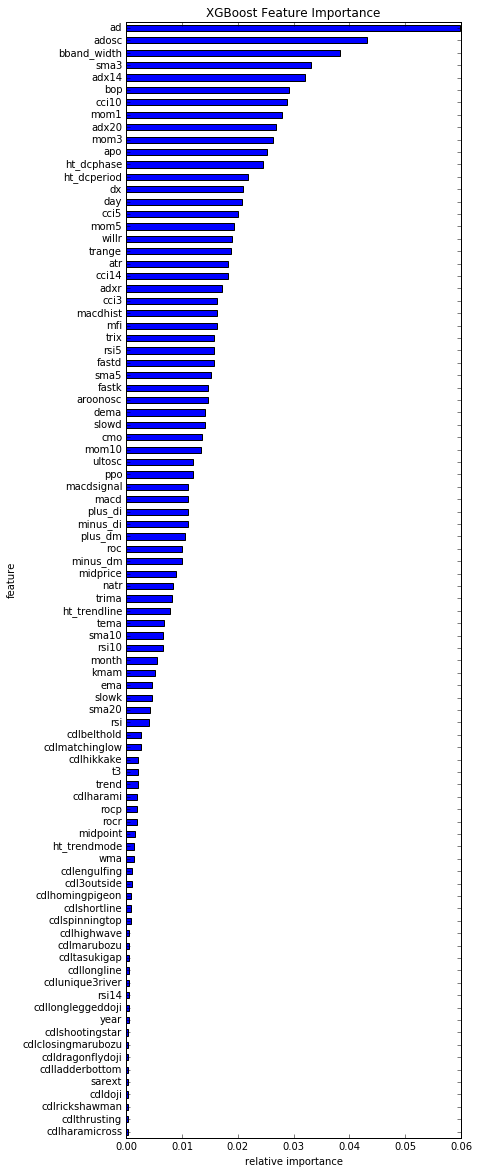

In [16]:
%matplotlib inline
from sklearn.cross_validation import train_test_split
import xgboost as xgb

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)


cursor = db.stock.find({"symbol": "GOOG"})
df = pd.DataFrame.from_dict(cursor[0]['data'])
train = df.set_index('Date')

# Without Adj Close/Open/High/Close/Volume
features = list(train.columns[6:])

print('training data processed')

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "nthread": 2,
          "seed": 1301
          }
num_boost_round = 100

print("Train a XGBoost model")
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = np.log1p(X_train['Adj Close'])
y_valid = np.log1p(X_valid['Adj Close'])
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid['Adj Close'].values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

# XGB feature importances
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 20))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()

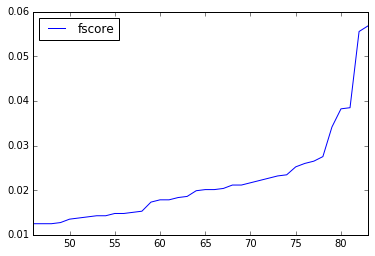

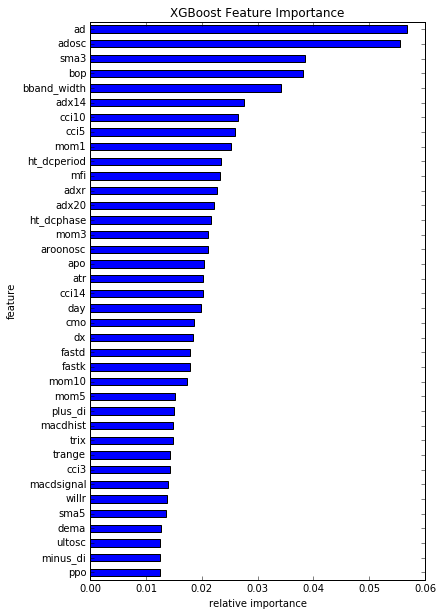

In [27]:
# Filter features based on mean
ff = df[df['fscore'] > df['fscore'].mean()]
ff.plot()
ff.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
# df[df['fscore'] > df['fscore'].mean()]['feature'].tolist()

In [ ]:
df[df['fscore'] > df['fscore'].mean()]['feature'].tolist()

## Classification - SVM

In [ ]:
from sklearn import datasets
from sklearn import svm
from sklearn import metrics
iris = datasets.load_iris()

C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
lin_svc = svm.LinearSVC(C=C)

for i, clf in enumerate((svc, rbf_svc, poly_svc)):
    clf.fit(iris.data, iris.target) 
    y_pred = clf.predict(iris.data)
    y_true = iris.target
    print(clf.kernel)
    print(metrics.accuracy_score(y_true, y_pred)) 
    print(metrics.precision_score(y_true, y_pred)) 
    print(metrics.recall_score(y_true, y_pred))
    print(metrics.f1_score(y_true, y_pred))
# clf.fit(iris.data, iris.target_names[iris.target]) 
iris
# list(clf.predict(iris.data[:3]))

In [18]:
from sklearn import svm
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

cursor = db.stock.find({"symbol": "GOOG"})
df = pd.DataFrame.from_dict(cursor[0]['data'])
df = df.tail(240)

X = df[['minus_di','slowd','mom10','ppo','macd','macdhist','willr','ultosc','macdsignal',
        'roc','cci14','fastk','plus_dm','day','trange','fastd','rsi5','aroonosc','minus_dm',
        'mfi','cci3','cmo','adxr','dx','atr','bband_width','mom5','cci10','adx20','cci5',
        'apo','ht_dcperiod','ht_dcphase','mom3','mom1','bop','adosc','adx14','sma3','ad']]

y = df['trend']

# X = SelectKBest(chi2, k=20).fit_transform(X, y)



X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.12, random_state=20)

C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
lin_svc = svm.LinearSVC(C=C)

for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_valid)
    print("Accuracy:" + str(metrics.accuracy_score(y_valid, y_pred)))
    print("Precision:" + str(metrics.precision_score(y_valid, y_pred)))
    print("Recall_score:" + str(metrics.recall_score(y_valid, y_pred)))
    print("F1_score:" + str(metrics.f1_score(y_valid, y_pred)))
    print()
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# ok = sel.fit_transform(train)
# print(train.shape)
# print(ok.shape)


Accuracy:0.275862068966
Precision:0.0760998810939
Recall_score:0.275862068966
F1_score:0.119291705499

Accuracy:0.310344827586

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None wil


Precision:0.0963139120095
Recall_score:0.310344827586
F1_score:0.147005444646

Accuracy:0.413793103448
Precision:0.171224732461
Recall_score:0.413793103448
F1_score:0.242220353238

Accuracy:0.413793103448
Precision:0.171224732461
Recall_score:0.413793103448
F1_score:0.242220353238



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample

In [28]:
df

,feature,fscore
0,cdllongleggeddoji,0.000255
1,cdlmorningstar,0.000255
2,cdlxsidegap3methods,0.000255
3,cdldojistar,0.000255
4,cdl3inside,0.000255
5,cdldoji,0.000255
6,cdlhighwave,0.000255
7,cdltasukigap,0.000255
8,rsi14,0.000510
9,year,0.000510
